# Utilities and Functions for Manipulating single-cell/ population Hi-C or ChIPseq data

So far all the functions I have been using have been written into the utils folder in this directory. Where possible, I have written up some utility functions in cython but other than that there are also python utils which you should feel free to add to. In general, all we're really doing is binning/ re-binning data. Getting the data into pytorch useable format is probably the hardest point here so i'll also dedicate some time to that. 

First though, modules...

In [3]:
import utils.processing as p
import utils.io as io
import utils.misc as misc
#from utils.GDC import GDC

from scipy.sparse import coo_matrix
from preprocessing.pop_HiC.formats.npz import load_npz_contacts as lnc
import torch

from sklearn.preprocessing import MinMaxScaler as MMS

import numpy as np
from numpy import int32
import pandas as pd
import h5py as h
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mplc
plt.style.use('seaborn-colorblind')
mpl.rcParams['figure.figsize'] = (10,10)

In [5]:
chr_lims = {'1': [3100000, 195220000],
            '10': [3100000, 130620000],
            '11': [3100000, 121920000],
            '12': [3200000, 120020000],
            '13': [3500000, 120220000],
            '14': [3100000, 124620000],
            '15': [3200000, 103920000],
            '16': [3400000, 98120000],
            '17': [3200000, 94920000],
            '18': [3100000, 90620000],
            '19': [3300000, 61220000],
            '2': [3200000, 182020000],
            '3': [3200000, 159920000],
            '4': [3500000, 156220000],
            '5': [3100000, 151720000],
            '6': [3200000, 149620000],
            '7': [3400000, 145320000],
            '8': [3300000, 129120000],
            '9': [3100000, 124320000],
            'X': [3600000, 170020000]}
IDdf, tvals = p.get_binned_feature("data/SLX-7671_haploid/raw/totalRNA.npz",
                                    chr_lims,
                                    5e4)

c_vals = p.get_binned_feature("/mnt/delphi/dh486/PhD/Data/AB_Compartment/c_score_regions_0hr.npz",
                              chr_lims,
                              5e4
                             )

IndexError: Out of bounds on buffer access (axis 0)

Let's also define all of the files where we have our structural data stored. Below we have:
- structure files in ".nuc" or ".hdf5" format (they're the same thing with different names)
- C-score files. This is the compartment score derived from population level Hi-C which has been pre-computed by the lab. It's up for debate whether this should be an input if we end up using the whole Hi-C graph as input since compartments are one of the most obvious learnable features from Hi-C maps. However, i've included them in this notebook anyway since they may prove useful as sanity checks.

In [2]:
root = "/mnt/delphi/dh486"
c_score_path = {0:"{}/PhD/jan_2019_scHi-C/local_enrichment/data/c_score_regions_0hr.npz".format(root),
                48:"{}/PhD/jan_2019_scHi-C/local_enrichment/data/c_score_regions_48hr.npz".format(root),
               'Rexhigh': "{}/PhD/jan_2019_scHi-C/local_enrichment/data/c_score_regions_24Rexpos.npz".format(root),
               'Rexlow':  "{}/PhD/jan_2019_scHi-C/local_enrichment/data/c_score_regions_24Rexlow.npz".format(root)
               }
void_path = {0:"data/void_0hrs.npz"}

structures_path = "{}/PhD/Data/nuc_files/".format(root)

structure_files_0hrs = ["P30G8_ambig_10x_100kb.nuc",
               "Cell_1_P2E8_ambig_10x_100kb.nuc", 
               "Cell_6_P30E8_ambig_10x_100kb.nuc",
               "Cell_7_UpL13_ambig_10x_100kb.nuc",
               "Cell_2_P30E4_ambig_10x_100kb.nuc",
               "Cell_8_P30D4_ambig_10x_100kb.nuc",
               "Cell_3_Q6_ambig_10x_100kb.nuc",
               "Cell_4_P2J8_ambig_10x_100kb.nuc",
               "P44F12_ambig_10x_100kb.nuc",
               "P44F6_ambig_10x_100.nuc",
               "Cell_5_P2I5_ambig_10x_100kb.nuc",
               "P44H4_ambig_10x_100kb.nuc"
                ]

structure_files_rexhigh = ["SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P62G7_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P62E12.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P62G8_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P62E6.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P62H10_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P62F11.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P62H13_100.hdf5"]

structure_files_rexlow = ["SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P63E9_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P63E14.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P63F8_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P63G12.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P63G10_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P63H14.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P63H10_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P63H7.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P63H9_100.hdf5",
                   "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P64E5.hdf5",
                   "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P64E11_100.hdf5"]

structure_files_48hrs = ["SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P45F10_100.hdf5", 
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P54G11_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P46D12_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P54G12_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P46G10_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P54G13_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P54E14_100.hdf5",
                         "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P46D6_100.hdf5",
                         "SLX-14520_INLINE_HNT7NBBXX_s_2_r_1_2_P54F7_100.hdf5",
                         "SLX-15484_INLINE_HTFK2BBXX_s_8_r_1_2_P54H12_100.hdf5"]

cell_list = {
            0:[structures_path + "0/" + item for item in structure_files_0hrs],
            48:[structures_path + "48/" + item for item in structure_files_48hrs],
            'Rexhi':[structures_path + "Rexhi/" + item for item in structure_files_rexhigh],
            'Rexlow':[structures_path + "Rexlow/" + item for item in structure_files_rexlow]
            }

all_cells = cell_list[0] + cell_list[48] + cell_list['Rexhi'] + cell_list['Rexlow']

num_cells = {0: len(structure_files_0hrs),
            48: len(structure_files_48hrs),
            'Rexhi': len(structure_files_rexhigh),
            'Rexlow': len(structure_files_rexlow)}

In [11]:
x = h.File(all_cells[0],'r')
print(x['dataTracks']['derived']['chromosomal_depth']['2'].shape)
x.close()

(10, 1791)


Below we also have the Population Hi-C data in ".ncc" format. Hopefully we shouldn't need to use this format directly as I am trying to write scripts to efficiently convert this all into a numpy array once we choose a specific binning of the genome. According to Dave who did the experimental processing, the overall resolution of the Hi-C data is probably around 50kb but this won't be even across the genome. For example, if we wanted to go to a higher resolution we could restrict our learning to regions of the genome which have particularly good data coverage

In [3]:
stem = '/mnt/delphi/dh486/PhD/GNN_Work/data/SLX-7671_haploid/raw/'
pophic = {0:stem + "SLX-7671_haploid_50kb.npz"
         }

Lets also include all the paths to our ChIPseq data which is stored on Delphi (our main backed-up storage unit)

In [16]:
import os
chipdatapaths = ["{}/PhD/Data/ChIPseq/peaks_bed_haploid_highconfidence".format(root),
                 "{}/PhD/Data/ChIPseq/peaks_bed".format(root),
                 "{}/PhD/Data/ChIPseq/peaks_bed/old_haploid".format(root)]
chiptracks = {}

for item in chipdatapaths:
    for file in os.listdir(item):
        if ".npz" in file:
            if "highconf" in file:
                name = "_".join(file.split(".")[0].split("_")[1:]) 
                chiptracks[name] = item + "/" + file
            else:
                name = "_".join(file.split(".")[0].split("_")[1:-1])
                chiptracks[name] = item + "/" + file

Finally lets include the RNAseq data which we could be using as our target variable in our regression problem:

In [17]:
rnanumpypath = {0:"{}/PhD/jan_2019_scHi-C/local_enrichment/data/mean_totalRNA_regions_0hr.npz".format(root),
                48:"{}/PhD/jan_2019_scHi-C/local_enrichment/data/mean_totalRNA_regions_48hr.npz".format(root),
               'Rexhi': "{}/PhD/jan_2019_scHi-C/local_enrichment/data/mean_totalRNA_regions_24high.npz".format(root),
                'Rexlow': "{}/PhD/jan_2019_scHi-C/local_enrichment/data/mean_totalRNA_regions_24low.npz".format(root)
               }
genenumpypath = "{}/PhD/jan_2019_scHi-C/local_enrichment/data/raw_gene_regions_0hr.npz".format(root)
gene_locs = "{}/PhD/Data/gene_data/mouse_genes.txt".format(root)

mse_path = "/data1/dh486/PhD/Data/major_satellite_repeats_mouse.txt"
mse_dict = "/data1/dh486/PhD/jan_2019_scHi-C/nuclear_depth/data/major_satellite_elements.npz"

In [18]:
def idx_to_bp(idx, chr_lims, binSize, chroms):
    
    ordering = {idx: chrom for idx, chrom in enumerate(chroms)}
    clens = {idx: int((chr_lims[ordering[idx]][-1] - chr_lims[ordering[idx]][0])/binSize) for idx in ordering}
    tot = 0
    for idx2 in np.arange(len(chroms)):
        tot += clens[idx2]
        if idx <= tot:
            chrom = ordering[idx2]
            chridx = idx - tot + clens[idx2]
            break
    
    return chrom, chr_lims[chrom][0] + chridx*binSize           
    
        
def bp_to_idx(bp, chrom, chr_lims, binSize, chroms):
    
    rounded_bp = binSize*np.floor(bp/binSize)
    chr_idx = int((rounded_bp - chr_lims[chrom][0])/binSize)
    tot = 0
    if chrom != 'X':
        for i in np.arange(1,int(chrom)):
            tot += (chr_lims[str(i)][1] - chr_lims[str(i)][0])/binSize
    else:
        for i in np.arange(1,20):
            tot += (chr_lims[str(i)][1] - chr_lims[str(i)][0])/binSize
    
    return int(tot + chr_idx)

def make_ptg_pophic_edge_index(file):
    x,y,z = lnc(file, store_sparse = True)
    
    
    order = ['chr' + str(i+1) for i in np.arange(19)] + ['chrX']
        
    offsets = np.cumsum([int((y[i][1]-y[i][0])/x) for i in order])
    shape = (offsets[-1], offsets[-1])
    offsets -= offsets[0]
    offsets = {chrom: offsets[i] for i, chrom in enumerate(order)}
    
    myrows = np.empty((1))
    mycols = np.empty((1))
    mydata = np.empty((1))
    for item in z.keys():
        z[item] = z[item].tocoo()
        
        chr1 = item[0]
        chr2 = item[1]
        if item[0] != 'chrY' and item[1] != 'chrY':
            rowadd = z[item].row + offsets[chr1]
            coladd = z[item].col + offsets[chr2]
    
            myrows = np.append(myrows, rowadd).astype(int)
            mycols = np.append(mycols, coladd).astype(int)
            mydata = np.append(mydata, z[item].data)
    
    del y['chrY']
    chr_lims = {chrom[3:]: y[chrom] for chrom in y}
    
    temp_coo = coo_matrix((mydata, (myrows, mycols)), shape = shape)
    
    edge_index = np.append(temp_coo.row[None,:], temp_coo.col[None,:], axis = 0)
    edge_attr = temp_coo.data[None,:]

    chroms = [str(i+1) for i in np.arange(19)] + ['X']
    backbone = np.zeros(edge_attr.shape)
    newindex = []
    newattr = []
    for idx in np.arange(edge_index.shape[0]):
        chrom, chrbp = idx_to_bp(idx, chr_lims , x, chroms)
        myidx_contacts_idxs = np.where(edge_index[0,:] == idx)[0]
    
        if idx + 1 not in myidx_contacts_idxs:
            chrom2, chrbp2 = idx_to_bp(idx+1, chr_lims, x, chroms)
            if chrom2 == chrom:
                newindex.append([idx,idx+1])
                #zero hi-c contacts, but backbone_contact == True
                newattr.append([0,1])
        for contact_idx in myidx_contacts_idxs:
            chrom2, chrbp2 = idx_to_bp(idx, chr_lims, x, chroms)
            if (chrom2 == chrom) and (abs(chrbp2 - chrbp) == x):
                backbone[contact_idx] = 1
        
    edge_index = np.append(edge_index, np.array(newindex).T, axis = 1)
    edge_attr = np.append(edge_attr, backbone, axis = 0)
    edge_attr = np.append(edge_attr, np.array(newattr).T, axis = 1).T  
    
    
    return  temp_coo.shape, x, chr_lims, torch.tensor(edge_index, dtype = torch.long), torch.tensor(edge_attr, dtype = torch.long)

def one_hot(chrom):    
    vals = np.zeros((1,20))
    
    try:
        c = int(chrom)
        vals[0,c-1] = 1
        return vals
    except:
        if chrom == 'X':
            vals[0,-1] = 1
            return vals
        else:
            raise ValueError
            
def make_basic_feature_matrix(chrlims):
    order = [str(i+1) for i in np.arange(19)] + ['X']
    
    totalfmat = np.empty((0,21))
    for chrom in order:
        onehot = one_hot(chrom).astype(int)
        
        lenchrom = int((chrlims[chrom][1] - chrlims[chrom][0])/binSize)
        chridxs = np.arange(chrlims[chrom][0], chrlims[chrom][1], binSize).astype(int)
        
        fmat = np.tile(onehot, (lenchrom,1))
        fmat = np.append(fmat, chridxs[:,None], axis = 1)
    
        totalfmat = np.append(totalfmat, fmat, axis = 0).astype(int)
        
    return torch.tensor(totalfmat, dtype = torch.long)


After defining these functions we can now simply call 'make_ptg_pophic_edge_index' (make pytorch geometric population hi-c edge index) on our .npz file which will give us our binSize, the limits of each chromosome and the entire population Hi-C matrix in COO format

In [19]:
mat_shape, binSize, chrlims, edge_index, edge_attr = make_ptg_pophic_edge_index(pophic[0])

In [20]:
mat_shape

(51456, 51456)

In [21]:
chrlims

{'1': (3000000, 195400000),
 '10': (3100000, 130700000),
 '11': (3100000, 122000000),
 '12': (3000000, 120150000),
 '13': (3000000, 120350000),
 '14': (3000000, 124950000),
 '15': (3050000, 104050000),
 '16': (3000000, 98250000),
 '17': (3000000, 95000000),
 '18': (3000000, 90750000),
 '19': (3050000, 61450000),
 '2': (3050000, 182150000),
 '3': (3000000, 160050000),
 '4': (3050000, 156400000),
 '5': (3000000, 151850000),
 '6': (3050000, 149750000),
 '7': (3000000, 145450000),
 '8': (3050000, 129350000),
 '9': (3000000, 124500000),
 'X': (3050000, 170800000)}

In [22]:
x,y,z = lnc(pophic[0],store_sparse = True)

In [23]:
temp2 = z[('chr19', 'chr19')].tocoo()

In [24]:
print(temp2.row, "\n", temp2.col, "\n", temp2.data)

[   0    0    0 ... 1167 1167 1167] 
 [ 159  202  211 ... 1162 1164 1165] 
 [1. 1. 2. ... 1. 1. 1.]


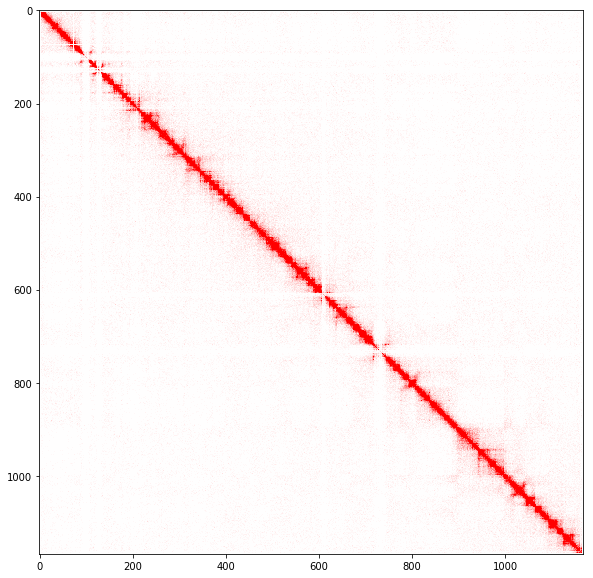

In [25]:
temp = z[('chr19', 'chr19')].toarray()
mpl.rcParams['figure.figsize'] = (10,10)
plt.imshow(temp, cmap = plt.cm.bwr, vmin = -np.percentile(temp, 99), vmax = np.percentile(temp, 99))

Once we have the basic matrix, we should add in the most basic features which will be present for all nodes in the matrix

In [26]:
fmat = make_basic_feature_matrix(chrlims)

In [27]:
fmat.shape

torch.Size([51456, 21])

Now we may want to add in transcriptional data as our output so let's bin this (and also keep per-gene data available as well)

In [28]:
########################################################################################################### 
# Get Transcriptional Data ################################################################################
geneIDdf = {} 
tvals = {}
for key in [0, 'Rexhi', 'Rexlow', 48]:
    geneIDdf[key], tvals[key] = io.binDatatrackIDs(rnanumpypath[key], chrlims, binSize = binSize)

In [45]:
########################################################################################################### 
# Get linear gene density for mESCs #######################################################################
_, gvals = io.binDatatrackIDs(genenumpypath, chrlims, binSize = binSize)

In [16]:
###########################################################################################################
# Average transcript per gene per bead ####################################################################
temp = {tpoint: np.zeros(np.shape(tvals[tpoint])) for tpoint in tvals.keys()}
for tpoint in tvals.keys():
    temp[tpoint][gvals!=0] = np.divide(tvals[tpoint][gvals!=0], gvals[gvals!=0])

###########################################################################################################
# Binning ChIPseq Tracks ##################################################################################
#Dictionary to hold our binned ChIPseq data
bb_chip_dict = {}
chroms = [str(i+1) for i in np.arange(19)] + ['X']
for key in chiptracks:
    b = []
    r,v = io.load_data_track(chiptracks[key])
    for chrom in r:
        for idx in np.arange(r[chrom].shape[0]):
            if abs(r[chrom][idx,1] - r[chrom][idx,0]) > 5e3:
                mean = 0.5*((r[chrom][idx,1] + r[chrom][idx,0]))
                r[chrom][idx, :] = np.array([mean - 1e3, mean + 1e3])
    t = io.binDataTrack(r,v, chrlims, binSize = 5e4)
    for chrom in chroms:
        b.append(t[chrom])
    
    b = np.concatenate(b)
    
    bb_chip_dict[key] = b

In [19]:
b.shape

(51476,)

In [18]:
###########################################################################################################
# Looking at Histone marks to define enhancers and promoters ##############################################
hmarkertracks = {'h3k4me3':chiptracks['H3K4me3_hapmESC_highconfpeaks'],
                 'h3k27ac':chiptracks['H3K27ac_hapmESC_highconfpeaks'],
                 'h3k27me3': chiptracks['H3K27me3_hapmESC_highconfpeaks'],
                 'h3k4me1':chiptracks['H3K4me1_hapmESC_highconfpeaks']}

###########################################################################################################
# Creating mESC Enhancer/Promoter Tracks ##################################################################################
lowres = 5e4
hires = 2e3
temp_hmarker_dict = {}
for key in hmarkertracks:
    b = []
    r,v = load.load_data_track(hmarkertracks[key])
    for chrom in r:
        for idx in np.arange(r[chrom].shape[0]):
            if abs(r[chrom][idx,1] - r[chrom][idx,0]) > 5e3:
                mean = 0.5*((r[chrom][idx,1] + r[chrom][idx,0]))
                r[chrom][idx, :] = np.array([mean - 1e3, mean + 1e3])
    t = load.binDataTrack(r,v, chrlims, binSize = hires)
    for chrom in chroms:
        b.append(t[chrom])
    
    b = np.concatenate(b)
    
    temp_hmarker_dict[key] = b
    
hires_dict = {}
#### THESE ARE GOING TO BE OUR HI RES SUBSETS#####
hires_dict['active_enhancers'] = (temp_hmarker_dict['h3k4me1'] > 0)&(temp_hmarker_dict['h3k27ac']>0)&(temp_hmarker_dict['h3k4me3']==0)
hires_dict['poised_enhancers'] = (temp_hmarker_dict['h3k4me1'] > 0)&(temp_hmarker_dict['h3k27ac']==0)&(temp_hmarker_dict['h3k4me3'] ==0)
hires_dict['enhancers'] = hires_dict['active_enhancers']|hires_dict['poised_enhancers']
hires_dict['bivalent_promoters'] = (temp_hmarker_dict['h3k27me3']>0)&(temp_hmarker_dict['h3k4me3'] >0)
hires_dict['active_promoters'] = (temp_hmarker_dict['h3k27ac']>0)&(temp_hmarker_dict['h3k4me3'] >0)

ratio = lowres/hires
glength = len(gvals)
lowres_dict = {}
for key in hires_dict:
    lowres_dict[key] = []
    for idx in np.arange(glength):
        try:
            lowres_dict[key].append(np.mean(hires_dict[key][int(ratio*idx):int(ratio*(idx+1))])>0)
        except:
            try:
                lowres_dict[key].append(np.mean(hires_dict[key][int(ratio*idx):])>0)
            except:
                append(0)
    
    lowres_dict[key] = np.array(lowres_dict[key])

for key in lowres_dict:
    bb_chip_dict[key] = lowres_dict[key]

In [19]:
bb_chip_dict.keys()

dict_keys(['H3K4me3_hapmESC_highconfpeaks', 'Smc3_hapmESC_highconfpeaks', 'Nanog_hapmESC_highconfpeaks_transcription_0', 'Klf4_hapmESC_highconfpeaks', 'H3K9me3_hapmESC_highconfpeaks', 'H3K4me1_hapmESC_highconfpeaks', 'Nanog_hapmESC_highconfpeaks_transcription_Rexlow', 'CTCF_hapmESC_highconfpeaks', 'Nanog_hapmESC_highconfpeaks', 'H3K27ac_hapmESC_highconfpeaks', 'Nanog_hapmESC_highconfpeaks_transcription_48', 'H3K36me3_hapmESC_highconfpeaks', 'Nanog_hapmESC_highconfpeaks_transcription_Rexhi', 'H3K27me3_hapmESC_highconfpeaks', 'H3K4me1_ESC', 'CTCF_CHD4ESC', 'Otx2_ESC', 'Nanog_ESC', 'Smc3_dipmESC', 'H3K9me3_MBD3nullESC', 'Med12_ESC', 'Klf4_Mbd3nullESC', 'H3K9me3_CHD4ESC', 'CTCF_dipmESC', 'Smc3_CHD4ESC', 'H3K27ac_ESC', 'Klf4_ESC', 'Smc3_OHTESC', 'H3K27me3_dipmESC', 'Nanog_Mbd3nullESC', 'H3K9me3_OHTESC', 'p300_ESC', 'H3K36me3_dipmESC', 'Med1_ESC', 'CTCF_OHTESC', 'CTCF_MBD3nullESC', 'H3K4me3_dipmESC', 'Nanog_dipmESC', 'Smc3_MBD3nullESC', 'Oct4_ESC', 'H3K9me3_dipmESC', 'Chd4_ESC', 'Mbd3_ESC', 

# Now we're ready to make our dataset!
Lets import pytorch first

In [56]:
import torch
import torch_geometric.data as tgd
import torch_geometric.io as tgio
import torch_geometric.transforms as T
from utils.my_transforms import GDC as gdc

... and finally create our dataset. For now the only edge attributes we will add are the Hi-C contact frequencies. Backbone edge data can be re-added later after we attempt to use graph diffusion convolution (detailed here https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html ) which is meant to improve GNN performance but requires only a single edge attribute. We'll therefore try and run diffusion on the Hi-C contact frequencies then detail which edges form the backbone later. 

In [87]:
data = tgd.Data(x = fmat, edge_index = edge_index, edge_attr = edge_attr[:,0], y = tvals[0])

Currently my actual node features are just the bare minimum ones. However, we could add whatever ChIPseq/depth/compartment information we wanted to. Since we're only interested in Population Hi-C as a baseline, lets only consider our base features plus some ChIPseq (information such as chromatin compartments should be implicit within the graph structure). 

However, we could feasibly be interested in using ChIPseq as well so lets put in:

- Nanog
- Klf4
- Oct4
- Smc3
- Med12
- Med1
- Mbd3
- Chd4
- p300
- CTCF
- Otx2
- H3K9me3
- H3K27me3
- H3K27ac
- H3K4me1
- H3K4me3
- H3K36me3
- Poised enhancers
- Active enhancers
- Bivalent promoters
- Active promoters

We'll also add in some structural data from the single-cell approaches:

- Nuclear Depth Mean/Standard Deviation
- Chromosomal Depth Mean/Standard Deviation
- Local Radius of Gyration Mean/Standard Deviation

Below is just a quick helper function which takes our single-cell data and interpolates it to whatever binSize we want before creating a long per-node feature vector which will eventually be added to our graph

In [37]:
def interpolate_sc_features(sc_file, feature, chrlims, binSize):
    chroms = [str(i+1) for i in np.arange(19)] + ['X']
    
    bdtrack = -np.ones(gvals.shape)
    f = h.File(sc_file,'r')

    mydtrack = f['dataTracks']['derived'][feature]
    mygenpos = {chrom: f['structures']['0']['particles'][chrom]['positions'] for chrom in mydtrack}
    for chrom in mydtrack:
        for idx, pos in enumerate(mygenpos[chrom]):
            try:
                popidx = bp_to_idx(pos + 0.5*binSize, chrom, chrlims, binSize, chroms)
                bdtrack[popidx] = np.mean(mydtrack[chrom][:, idx])
            except:
                print(chrom, pos, popidx)

    f.close()

    from scipy.interpolate import CubicSpline

    interpolationpoints = {chrom : [idx_to_bp(idx, chrlims, binSize, chroms)[1] + 0.5*binSize for idx in np.where(bdtrack > -1)[0] if idx_to_bp(idx, chrlims, binSize, chroms)[0] == chrom]for chrom in chroms}
    cs = {chrom: CubicSpline(interpolationpoints[chrom],
                         [bdtrack[idx] for idx in np.where(bdtrack > -1)[0] if idx_to_bp(idx, chrlims, binSize, chroms)[0] == chrom]
                        ) for chrom in chroms}

    maxval = np.max(bdtrack[bdtrack > -1])
    minval = np.min(bdtrack[bdtrack > -1])
    for idx in np.arange(len(bdtrack)):
        if bdtrack[idx] == -1:
            chrom, bp = idx_to_bp(idx, chrlims, binSize, chroms)
            bdtrack[idx] = np.maximum(minval, np.minimum(maxval,cs[chrom](bp + 0.5*binSize)))
            
    
    return bdtrack

In [49]:
for feature in ['nuclear_depth', 'local_RoG2Mb', 'chromosomal_depth']:
    print(feature + "...")
    scfmat = np.empty((1,gvals.shape[0]))
    for file in cell_list[0]:
        x = interpolate_sc_features(file, feature, chrlims, binSize)[None,:]
        scfmat = np.append(scfmat,x, axis = 0)
        
    means = np.mean(scfmat, axis = 0)
    std = np.std(scfmat, axis = 0)
    
    bb_chip_dict['mean_' + feature] = means
    bb_chip_dict['std_' + feature] = std
    
    print('done')

nuclear_depth...
X 170800000.0 51456
done
local_RoG2Mb...
X 170800000.0 51456
done
chromosomal_depth...
X 170800000.0 51456
done


Lets just list all of our features here and then add them into our feature matrix!

In [79]:
ourfeaturenames = ['Nanog_hapmESC_highconfpeaks',
                   'Klf4_hapmESC_highconfpeaks',
                   'Oct4_ESC',
                   'Smc3_hapmESC',
                   'Med12_ESC',
                   'Med1_ESC',
                   'Mbd3_ESC',
                   'Chd4_ESC',
                   'p300_ESC',
                   'CTCF_hapmESC',
                   'Otx2_ESC',
                   'H3K9me3_hapmESC_highconfpeaks',
                   'H3K27me3_hapmESC_highconfpeaks',
                   'H3K27ac_hapmESC_highconfpeaks',
                   'H3K4me1_hapmESC_highconfpeaks',
                   'H3K4me3_hapmESC_highconfpeaks',
                   'H3K36me3_hapmESC_highconfpeaks',
                   'bivalent_promoters',
                   'active_promoters',
                   'poised_enhancers',
                   'active_enhancers',
                   'mean_nuclear_depth',
                   'std_nuclear_depth',
                   'mean_chromosomal_depth',
                   'std_chromosomal_depth',
                   'mean_local_RoG2Mb',
                   'std_local_RoG2Mb'
                  ]

featureidxs = {name: 21 + idx for idx, name in enumerate(ourfeaturenames)}



In [88]:
fmat = make_basic_feature_matrix(chrlims)
for chipseq in ourfeaturenames:
    fmat = torch.cat((fmat, torch.tensor(bb_chip_dict[chipseq][:,None], dtype = torch.long)), dim = 1)

In [89]:
#normalise our features by column
for col in np.arange(fmat.shape[1]):
    scaler = MMS()
    x = scaler.fit_transform(fmat[:,col][:,None])
    fmat[:,col] = torch.tensor(x[:,0], dtype = torch.long)

data.x = fmat

Finally let's include data regarding what each of our feature columns means

In [90]:
data.featureidxs = featureidxs

In [91]:
data

Data(edge_attr=[31280210], edge_index=[2, 31280210], featureidxs={'Nanog_hapmESC_highconfpeaks': 21, 'Klf4_hapmESC_highconfpeaks': 22, 'Oct4_ESC': 23, 'Smc3_hapmESC': 24, 'Med12_ESC': 25, 'Med1_ESC': 26, 'Mbd3_ESC': 27, 'Chd4_ESC': 28, 'p300_ESC': 29, 'CTCF_hapmESC': 30, 'Otx2_ESC': 31, 'H3K9me3_hapmESC_highconfpeaks': 32, 'H3K27me3_hapmESC_highconfpeaks': 33, 'H3K27ac_hapmESC_highconfpeaks': 34, 'H3K4me1_hapmESC_highconfpeaks': 35, 'H3K4me3_hapmESC_highconfpeaks': 36, 'H3K36me3_hapmESC_highconfpeaks': 37, 'bivalent_promoters': 38, 'active_promoters': 39, 'poised_enhancers': 40, 'active_enhancers': 41, 'mean_nuclear_depth': 42, 'std_nuclear_depth': 43, 'mean_chromosomal_depth': 44, 'std_chromosomal_depth': 45, 'mean_local_RoG2Mb': 46, 'std_local_RoG2Mb': 47}, x=[51456, 48], y=[ 0.          0.          0.         ...  0.         10.21839083
  0.        ])

## Graph Diffusion Convolution

I'm running here graph diffusion on our dataset for each of the features named above based on the code provided on the pytorch geometric website

In [82]:
my_gdc = gdc(self_loop_weight=1, normalization_in='sym',
                normalization_out='col',
                diffusion_kwargs=dict(method='ppr', alpha=0.05),
                sparsification_kwargs=dict(method='topk', k=128,
                                           dim=0), exact=True)
data = my_gdc(data)

RuntimeError: value cannot be converted to type int64_t without overflow: inf

As can be seen - we hit an overflow bug and I think this is because I am trying to run this particular transform on a CPU rather than a GPU. This could be easily fixed since we have GPU access so in this case i'm going to re-add the backbone edge information and save the data object to be reloaded easily in the future.

This notebook can just be copied for further processing of population hi-C datasets from future timepoints etc. 

In [102]:
#Re-adding the backbone edge data
data.edge_attr = edge_attr

# EXAMPLE GAT MODEL

In [ ]:
data.train_idx = train_idx
data.test_idx = test_idx
data.val_idx = val_idx

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(
            8 * 8, 10, heads=1, concat=True, dropout=0.6)

    def forward(self):
        x = F.dropout(data.x, p=0.8, training=self.train_idx)
        x = F.relu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.8, training=self.train_idx)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, *test()))

# Misc Stuff - Ignore

In [22]:
def set_node_attributes(G, name, values):
    try:
        values.items
    except AttributeError:
        # Treat `value` as the attribute value for each node.
        values = dict(zip(G.nodes(), [values] * len(G)))

    for node, value in values.items():
        G.node[node][name] = value
        
def set_edge_attributes(G, name, values):
    try:
        values.items
    except AttributeError:
        # Treat `value` as the attribute value for each edge.
        if G.is_multigraph():
            edges = G.edges(keys=True)
        else:
            edges = G.edges()
        values = dict(zip(edges, [values] * len(edges)))

    if G.is_multigraph():
        for (u, v, key), value in values.items():
            G[u][v][key][name] = value
    else:
        for (u, v), value in values.items():
            G[u][v][name] = value

def nx_contact_graph(npz_file,
                     normalize = True,
                     inc_features = False,
                     features = {}):
    shape, binSize, chr_lims, edge_index, edge_attr = make_ptg_pophic_edge_index(npz_file)  
    
    print(shape)
    #Make our output graph object
    G = nx.Graph()
    G.add_nodes_from(np.arange(shape[0]))
    chroms = [str(i+1) for i in np.arange(19)] + ['X']
    set_node_attributes(G, 'chrom', {idx: idx_to_bp(idx, chr_lims, binSize, chroms)[0] for idx in G.nodes()})
    set_node_attributes(G, 'bp', {idx: idx_to_bp(idx, chr_lims, binSize, chroms)[1] for idx in G.nodes()})
    
    if inc_features:
        feature_dict = {}
        IDdict = {}
        for feature in features:
            file = features[feature]
            try:
                IDdf, fvals = load.binDatatrackIDs(file, chrranges, chr_lims, binSize = binSize)
                feature_dict[feature] = fvals
                IDdict[feature] = IDdf
            except:
                b = []
                r,v = load.load_data_track(file)
                for chrom in r:
                    for idx in np.arange(r[chrom].shape[0]):
                        if abs(r[chrom][idx,1] - r[chrom][idx,0]) > 5e3:
                            mean = 0.5*((r[chrom][idx,1] + r[chrom][idx,0]))
                            r[chrom][idx, :] = np.array([mean - 1e3, mean + 1e3])
                t = load.binDataTrack(r,v, chr_lims, binSize = binSize)
                for chrom in chroms:
                    b.append(t[chrom])
    
                b = np.concatenate(b)
                b = MMS().fit_transform(b)
            
                feature_dict[feature] = fvals
                
                

        for feature in feature_dict:
            nx.set_node_attributes(G, feature, {idx: features[key][idx]})
        for feature in ID_dict:
            ID_attr = {}
            for val in set(ID_dict[feature].values[0,:]):
                idxs = np.where(ID_dict[feature].values[0,:] == val)
                ID_attr[val] = ID_dict.columns.values[idxs]
            nx.set_node_attributes(G, feature + "_IDs", ID_attr)
    
    G.add_edges_from([(edge_index[0,idx], edge_index[1,idx]) for idx in np.arange(edge_index.shape[1])])
    set_edge_attributes(G, 'backbone', {(edge_index[0,idx], edge_index[1,idx]): edge_attr[idx,1] for idx in np.arange(edge_index.shape[1])})
    set_edge_attributes(G, 'freq', {(edge_index[0,idx], edge_index[1,idx]): edge_attr[idx,0] for idx in np.arange(edge_index.shape[1])})
    
    return G, chr_lims, binSize   

def get_local_contact_graph(G,
                            chrom,
                            pos,
                            numhops,
                            binSize = 1e5,
                            ncutoff = 50):
    
    chroms = [str(i+1) for i in np.arange(19)] + ['X']
    idx = bp_to_idx(pos, chrom, chr_lims, binSize, chroms)
    
    cutoffnodes = nx.single_source_shortest_path_length(graph, idx, cutoff=numhops)
    
    subG = graph.subgraph([idx for idx in cutoffnodes])
    
    cutoffedges = [(item[0], item[1], item[2]['freq']) for item in subG.edges(data = True)]
    idxs = np.argsort(np.array([item[2] for item in cutoffedges]))
    
    
    closeedges = [cutoffedges[idx] for idx in idxs[:ncutoff]]
    closenodes = list(set([item[0] for item in closeedges] + [item[1] for item in closeedges]))
    
    nsubG = subG.subgraph(closenodes)
    
    return nsubG, nodename

In [8]:
G, chrlims, binSize = nx_contact_graph(pophic[0])

(51456, 51456)


In [10]:
get_local_contact_graph(G,'12',6000000,1,binSize = 1e5,ncutoff = 50)

NameError: name 'chr_lims' is not defined

In [ ]:
def draw_local_graph_spring_pos(G,
                                chrom,
                                pos,
                                numhops,
                                locusname = '',
                                binSize = 1e5,
                                gtype = 'contact',
                                num_nearest = 50,
                                cellname = ''
                               ):

    mpl.rcParams['figure.figsize'] = (10,10)
   
    if gtype == 'contact':   
        temp, centralnode = get_local_contact_graph(G, chrom, pos, numhops, binSize = binSize, ncutoff = 50)
    else:
        temp, centralnode = get_local_contact_graph(G, chrom, pos, 1, binSize = binSize, ncutoff = 50)

    
    pos=nx.spring_layout(temp)
    chroms = [item.split("/")[0]for item in temp.nodes()]
        
    print(temp.nodes())
    backbone_edges = [item for item in temp.edges() if 
            ((abs(int(item[0].split("/")[-1]) - int(item[1].split("/")[-1])) < 1.5*binSize) and
            (item[0].split("/")[0] == item[1].split("/")[0]))]
    non_backbone_edges = [item for item in temp.edges() if item not in backbone_edges]
    involved_chroms = list(set(chroms))
    involved_chroms = [centralnode.split("/")[0]] + [item for item in involved_chroms if centralnode.split("/")[0] not in item]

    cmap = plt.cm.Set1
    colors = {chrom: mplc.to_hex(cmap(idx)) for idx, chrom in enumerate(involved_chroms)}


    for idx,chrom in enumerate(involved_chroms):
        chromlabel = True
        chr_edges = [item for item in backbone_edges if chrom in item[0].split("/")[0]]
        chr_nodes = [item for item in temp.nodes() if chrom in item.split("/")[0]]
    

        edge_cols = np.full(len(chr_edges), idx)
        node_cols = np.full(len(chr_nodes), idx)
    
        if len(chr_edges) > 0:
            if chromlabel:
                nx.draw_networkx_edges(temp,
                               pos,
                               edgelist = chr_edges,
                               width = 2.0,
                               edge_color = colors[chrom],
                               label = "Chr{} Backbone".format(chrom))
            else:
                nx.draw_networkx_edges(temp,
                               pos,
                               edgelist = chr_edges, 
                               width = 2.0,
                               edge_color = colors[chrom])
                chromlabel = False
            
            nx.draw_networkx_nodes(temp,
                           pos,
                           nodelist = chr_nodes,
                           node_size = 10,
                           node_color = colors[chrom],
                           with_labels = False)
        else:
            nx.draw_networkx_nodes(temp,
                           pos,
                           nodelist = chr_nodes,
                           node_size = 10,
                           node_color = colors[chrom],
                           with_labels = False, label = "Chr {}".format(chrom))

    
    if gtype == 'contact':
        nx.draw_networkx_edges(temp, pos, edge_color = 'black', style = 'dashed', alpha = 0.2, label = 'snHi-C Contact')
    else:
        dists = [edge[-1] for edge in temp.edges(data='weight')]
        maxdist = np.max(dists)
        mindist = np.min(dists)
        for edge in temp.edges(data='weight'):
            dist = edge[-1]
            alpha = 0.1 + 0.8*(dist - mindist)/(maxdist - mindist)
            nx.draw_networkx_edges(temp, pos, edgelist = [edge], edge_color = 'black', style = 'dashed', alpha = alpha)

    # Draw ego as large and red
    nx.draw_networkx_nodes(temp,pos,nodelist=[centralnode],node_size=400,node_color= '#ff00ffff', label = locusname)
    plt.legend(markerscale = 0.5, prop={'size':15}, bbox_to_anchor = [1.1,1])
    plt.title("Local {} Graph Structure, Cell {}".format(locusname, cellname), size = 15)
    plt.xticks([],[])
    plt.yticks([],[])  

In [ ]:
def get_local_contact_graph(graph, chrom, pos, numhops, binSize = 1e5, ncutoff = 50):
    roundedpos = int(np.floor(pos/binSize)*binSize)
    nodename = str(chrom) + "/" + str(roundedpos)
    
    cutoffnodes = nx.single_source_shortest_path_length(graph, nodename, cutoff=numhops)
    
    subG = graph.subgraph([key for key in cutoffnodes])
    
    cutoffedges = [(item[0], item[1], item[2]['weight']) for item in subG.edges(data = True)]
    idxs = np.argsort(np.array([item[2] for item in cutoffedges]))
    
    
    closeedges = [cutoffedges[idx] for idx in idxs[:ncutoff]]
    closenodes = list(set([item[0] for item in closeedges] + [item[1] for item in closeedges]))
    
    nsubG = subG.subgraph(closenodes)
    
    return nsubG, nodename

In [ ]:
G, lims, binSize = contact_graph(pophic[0])

In [ ]:
temp, n = get_local_contact_graph(G,'chr6',12000000, 1, binSize = 5e4)

In [ ]:
draw_local_graph_spring_pos(G,
                            'chr6',
                            12000000,
                            1,
                            locusname = '',
                            binSize = 5e4,
                            gtype = 'dist',
                            num_nearest = 10)